<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/RNN%20ECG%20forecast%20timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.4 MB/s eta 0:00:00


In [2]:
# Install required packages if needed (uncomment if running for the first time)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data

In [11]:

# --- 1. Load and Prepare ECG Data ---
print("Loading ECG data...")
df = pd.read_csv('ecg_1d_timeseries_prediction.csv', delimiter=';')
print(df.head())
print(f"Total data points: {len(df)}")
dt_calculated = df['time'].diff().mean()
print(f"Calculated time step (dt): {dt_calculated:.6f}s (Implies Fs = {1/dt_calculated:.2f} Hz)")
fs = 1/dt_calculated

time_full = df['time'].values
ecg_full = df['ecg_value'].values
ecg_full = ecg_full - ecg_full.mean()

# Define split: last 1 seconds for testing
test_duration_sec = 0.5
sampling_rate = int(np.round(1.0 / dt_calculated))
test_points = int(test_duration_sec * sampling_rate)

print(f"Assumed Sampling Rate: {sampling_rate} Hz")
print(f"Test Points (last {test_duration_sec}s): {test_points}")

time_train = time_full[:-test_points]
ecg_train = ecg_full[:-test_points]
time_test = time_full[-test_points:]
ecg_test_true = ecg_full[-test_points:]

print(f"Training points: {len(ecg_train)} ({time_train[-1] - time_train[0]:.2f}s)")
print(f"Testing points: {len(ecg_test_true)} ({time_test[-1] - time_test[0]:.2f}s)")

Loading ECG data...
    time  ecg_value
0  0.000        496
1  0.001        496
2  0.002        497
3  0.003        498
4  0.004        498
Total data points: 17935
Calculated time step (dt): 0.001000s (Implies Fs = 1000.00 Hz)
Assumed Sampling Rate: 1000 Hz
Test Points (last 0.5s): 500
Training points: 17435 (17.43s)
Testing points: 500 (0.50s)


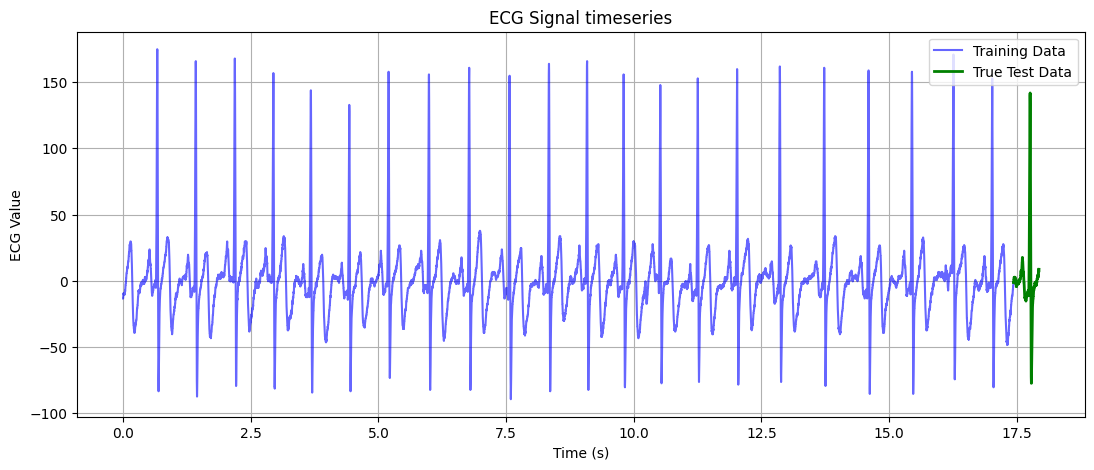

In [12]:
# Plot 1: Full time series with predictions highlighted
fig, axes = plt.subplots(1, 1, figsize=(13, 5))

axes.plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
axes.plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
axes.set_title('ECG Signal timeseries')
axes.set_xlabel('Time (s)')
axes.set_ylabel('ECG Value')
axes.legend()
axes.grid(True)

# Filter timeseries

In [13]:
def plot_fft_spectrum_compare(ecg_full, time_full, ecg_filtered_data, time_filtered):
  # Calculate sampling rates
  dt_full = time_full[1] - time_full[0]
  fs_full = 1 / dt_full

  dt_filterd = time_filtered[1] - time_filtered[0]
  fs_filered = 1/ dt_filterd

  #fs_full = len(time_full) / (time_full[-1] - time_full[0])

  # Compute FFT for original downsampled signal
  fft_ecg_full = np.fft.fft(ecg_full)
  freqs_full = np.fft.fftfreq(len(ecg_full), d=dt_full) # Use original dt for frequency scale

  # Compute FFT for DWT downsampled approximation
  fft_ecg_filtered = np.fft.fft(ecg_filtered_data)
  freqs_ecg_filtered = np.fft.fftfreq(len(ecg_filtered_data), d=dt_filterd) # Use original dt for frequency scale (matches downsampled signal length)


  # Take only the positive half of the FFT (and corresponding frequencies) for plotting
  freqs_full_half = freqs_full[:(len(freqs_full) // 2)]
  fft_full_half = fft_ecg_full[:(len(fft_ecg_full) // 2)]

  freqs_ecg_filtered_half = freqs_ecg_filtered[:len(freqs_ecg_filtered) // 2]
  fft_ecg_filtered_half = fft_ecg_filtered[:len(fft_ecg_filtered) // 2]

  # Calculate magnitude spectra
  magnitude_full = np.abs(fft_full_half)
  magnitude_filtered = np.abs(fft_ecg_filtered_half)

  # --- Plotting ---
  plt.figure(figsize=(13, 5))

  plt.plot(freqs_full_half, magnitude_full, label='FFT Magnitude: Original', alpha=0.8, linewidth=0.8)
  plt.plot(freqs_ecg_filtered_half, magnitude_filtered, label='FFT Magnitude: filtered', color='red', linewidth=0.8)
  plt.title('FFT Magnitude Comparison (Frequency Domain)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Magnitude')
  plt.legend()
  plt.grid(True, alpha=0.3)
  # Limit x-axis to show frequencies up to the Nyquist frequency of the downsampled signal
  plt.xlim(0, fs_full / 20)

  plt.tight_layout()
  plt.show()

In [14]:
from scipy.signal import butter, filtfilt
order = 5
cutoff_frequency = 15.0 # Hz
nyquist = 0.5 * fs
normal_cutoff = cutoff_frequency / nyquist

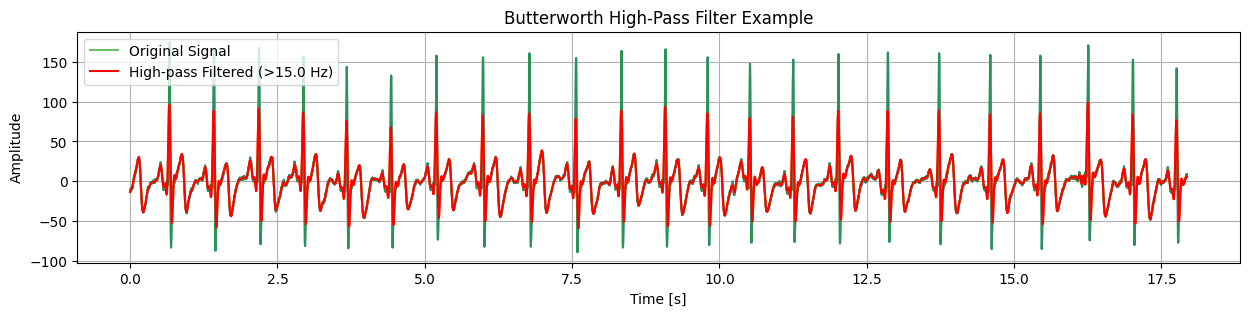

In [15]:
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

# 4. Apply the filter to the data
ecg_filtered_data = filtfilt(b, a, ecg_full)
plt.figure(figsize=(15,3))
plt.plot(time_full,ecg_full, time_full, ecg_filtered_data)

plt.plot(time_full, ecg_full, label='Original Signal', alpha=0.7)
plt.plot(time_full, ecg_filtered_data, label=f'High-pass Filtered (>{cutoff_frequency} Hz)', color='red')
plt.title('Butterworth High-Pass Filter Example')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

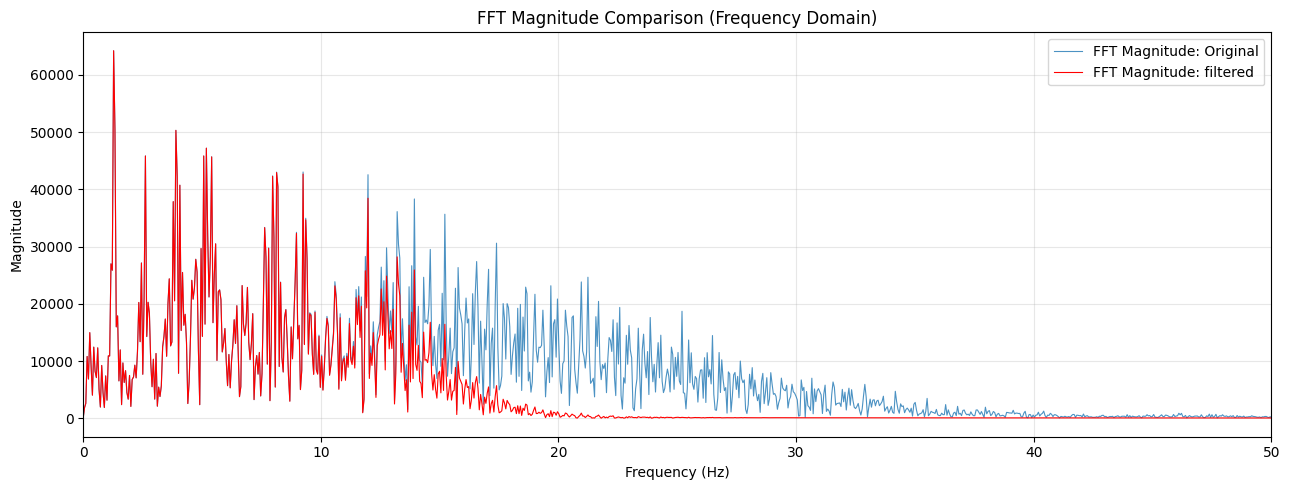

In [16]:
plot_fft_spectrum_compare(ecg_full, time_full, ecg_filtered_data, time_full)

# Downsample timeseries with DWT

In [17]:
import pywt

Original ECG length: 17935
Maximum possible decomposition level for this signal: 11
DWT Approximation (Level 4) length: 1127


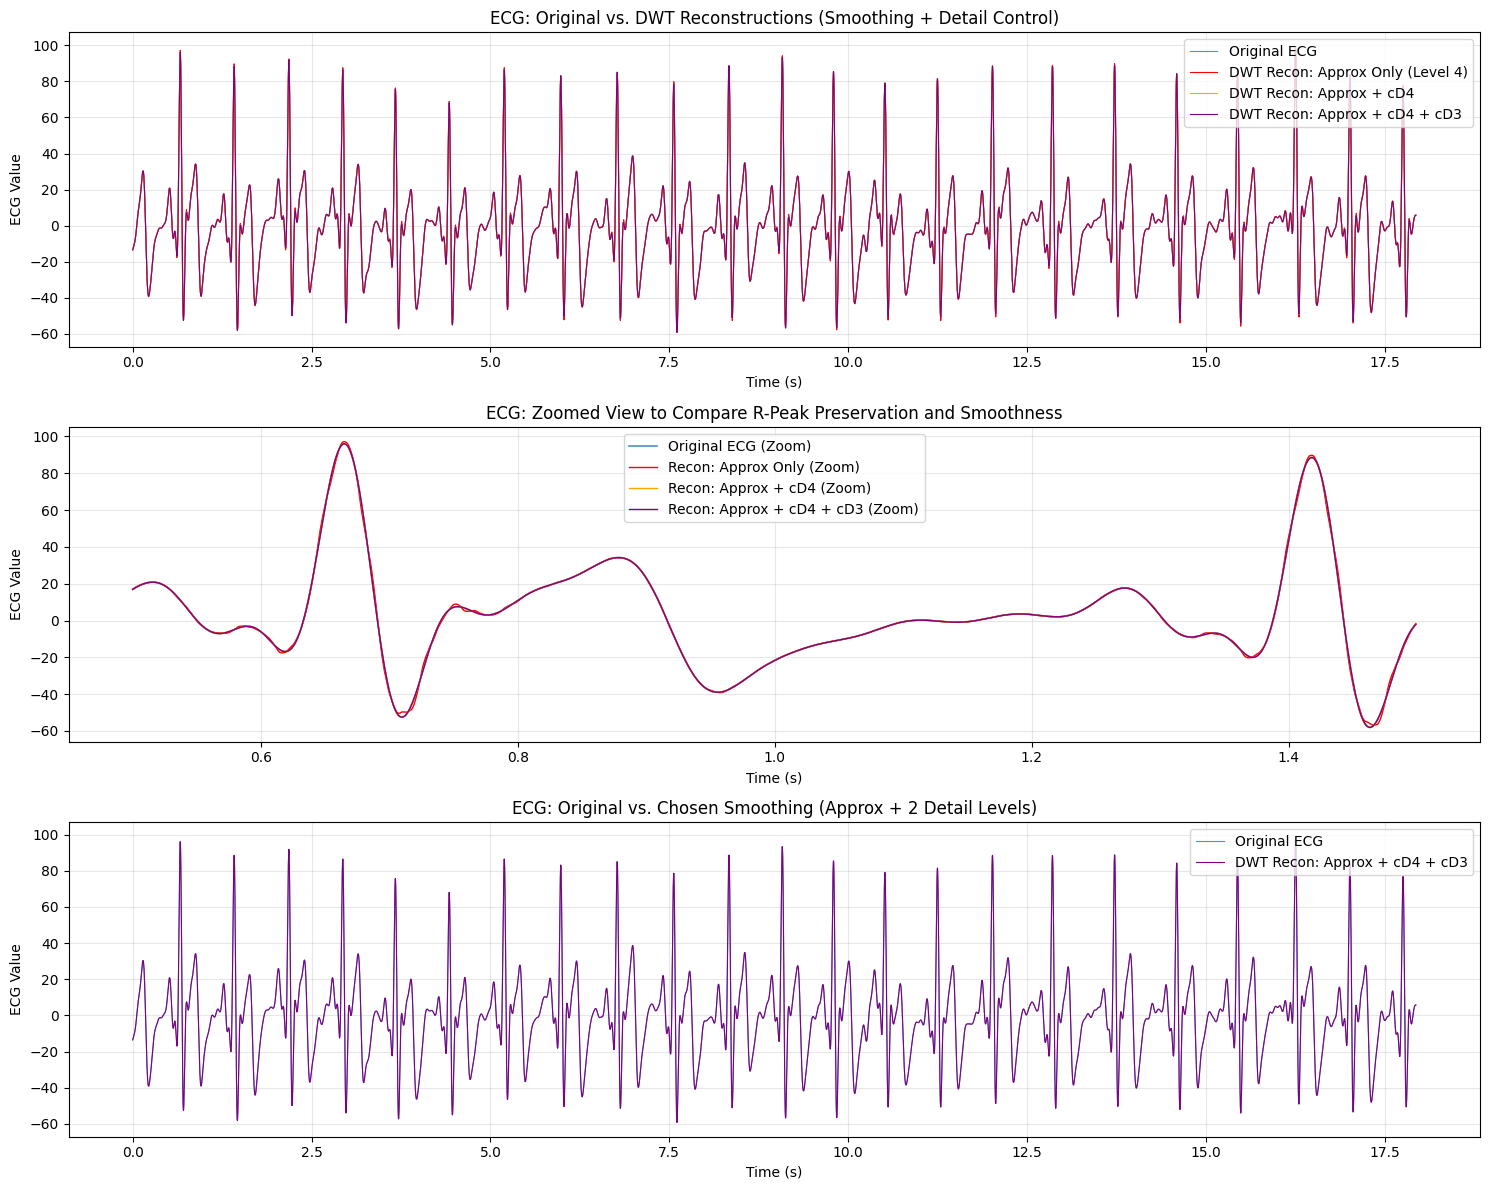


--- Error Metrics for Chosen Reconstruction (Approx + cD4 + cD3) ---
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0036
Mean Absolute Error (MAE): 0.0016
Maximum Absolute Error: 0.1363

Length of approx_coeffs (downsampled signal): 1127
Length of chosen reconstruction (original length): 17935
Length of downsampled time vector for approx_coeffs: 1127


In [18]:
print(f"Original ECG length: {len(ecg_filtered_data)}")

# --- Filter and Smooth using DWT Reconstruction ---
# --- Resample using DWT --- # coif5, db4, sym7
wavelet_name = 'db4'
# Choose the total number of levels for decomposition
# We will use ALL levels for decomposition to get all coefficients
max_level = pywt.dwt_max_level(len(ecg_filtered_data), pywt.Wavelet(wavelet_name))
print(f"Maximum possible decomposition level for this signal: {max_level}")

# For smoothing while keeping some detail, let's decompose to a reasonable level
# and then reconstruct using only the approximation and first 1-2 detail levels.
decomposition_level = 4 # Adjust this level as needed

# Perform the full decomposition up to the specified level
coeffs = pywt.wavedec(ecg_filtered_data, wavelet_name, level=decomposition_level)
approx_coeffs = coeffs[0] # The smooth, low-frequency part

# --- Reconstruction Strategy ---
# To get a smoother signal that still has some sharp features (like R-peaks),
# reconstruct using the approximation coefficients (cA) and the first few detail coefficient sets (cD).
# Example: Reconstruct using cA (level 4) + cD4 + cD3
# The more detail levels you include (starting from the highest level), the less smooth and more detailed the output becomes.

# Let's reconstruct using only the approximation (cA) - this is the coarsest, smoothest version
reconstructed_smooth_only = pywt.waverec([approx_coeffs] + [np.zeros_like(c) for c in coeffs[1:]], wavelet_name)
# Ensure the reconstructed length matches the original (DWT might add padding)
reconstructed_smooth_only = reconstructed_smooth_only[:len(ecg_filtered_data)]

# Let's reconstruct using the approximation (cA) AND the first (highest) level of detail (cD4)
# This adds back the highest scale (lowest frequency) details, including major peaks/transitions
detail_levels_to_keep = 1 # Keep cD4 (the first one returned by wavedec)
reconstruction_coeffs = [approx_coeffs] + coeffs[1:1+detail_levels_to_keep] + [np.zeros_like(c) for c in coeffs[1+detail_levels_to_keep:]]
reconstructed_smooth_with_details_1 = pywt.waverec(reconstruction_coeffs, wavelet_name)
reconstructed_smooth_with_details_1 = reconstructed_smooth_with_details_1[:len(ecg_filtered_data)]

# Let's reconstruct using the approximation (cA) AND the first TWO levels of detail (cD4, cD3)
# This adds back more detail, potentially sharper R-peaks
detail_levels_to_keep = 2 # Keep cD4 and cD3
reconstruction_coeffs = [approx_coeffs] + coeffs[1:1+detail_levels_to_keep] + [np.zeros_like(c) for c in coeffs[1+detail_levels_to_keep:]]
reconstructed_smooth_with_details_2 = pywt.waverec(reconstruction_coeffs, wavelet_name)
reconstructed_smooth_with_details_2 = reconstructed_smooth_with_details_2[:len(ecg_filtered_data)]

# Let's also get the full reconstruction (all levels) for comparison
reconstructed_full = pywt.waverec(coeffs, wavelet_name)
reconstructed_full = reconstructed_full[:len(ecg_filtered_data)]

print(f"DWT Approximation (Level {decomposition_level}) length: {len(approx_coeffs)}")

# --- Plotting ---
plt.figure(figsize=(15, 12))

# Plot 1: Original vs. Various Reconstructions
plt.subplot(3, 1, 1)
plt.plot(time_full, ecg_filtered_data, label='Original ECG', alpha=0.8, linewidth=0.8)
plt.plot(time_full, reconstructed_smooth_only, label=f'DWT Recon: Approx Only (Level {decomposition_level})', color='red', linewidth=0.8)
plt.plot(time_full, reconstructed_smooth_with_details_1, label=f'DWT Recon: Approx + cD{decomposition_level}', color='orange', linewidth=0.8)
plt.plot(time_full, reconstructed_smooth_with_details_2, label=f'DWT Recon: Approx + cD{decomposition_level} + cD{decomposition_level-1}', color='purple', linewidth=0.8)
plt.title('ECG: Original vs. DWT Reconstructions (Smoothing + Detail Control)')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoom on a section to see R-peaks and smoothness
start_idx = int(0.5 / 0.001)  # Start around 0.5 seconds (assuming dt ~ 0.001)
end_idx = int(1.5 / 0.001)    # End around 1.5 seconds
time_zoom = time_full[start_idx:end_idx]
ecg_orig_zoom = ecg_filtered_data[start_idx:end_idx]
recon_smooth_only_zoom = reconstructed_smooth_only[start_idx:end_idx]
recon_smooth_d1_zoom = reconstructed_smooth_with_details_1[start_idx:end_idx]
recon_smooth_d2_zoom = reconstructed_smooth_with_details_2[start_idx:end_idx]

plt.subplot(3, 1, 2)
plt.plot(time_zoom, ecg_orig_zoom, label='Original ECG (Zoom)', alpha=0.8, linewidth=1.2)
plt.plot(time_zoom, recon_smooth_only_zoom, label='Recon: Approx Only (Zoom)', color='red', linewidth=1)
plt.plot(time_zoom, recon_smooth_d1_zoom, label='Recon: Approx + cD4 (Zoom)', color='orange', linewidth=1)
plt.plot(time_zoom, recon_smooth_d2_zoom, label='Recon: Approx + cD4 + cD3 (Zoom)', color='purple', linewidth=1)

plt.title('ECG: Zoomed View to Compare R-Peak Preservation and Smoothness')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Compare Original to Reconstruction with 2 Detail Levels (Main Choice)
plt.subplot(3, 1, 3)
plt.plot(time_full, ecg_filtered_data, label='Original ECG', alpha=0.8, linewidth=0.8)
plt.plot(time_full, reconstructed_smooth_with_details_2, label=f'DWT Recon: Approx + cD{decomposition_level} + cD{decomposition_level-1}', color='purple', linewidth=0.8)
plt.title('ECG: Original vs. Chosen Smoothing (Approx + 2 Detail Levels)')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The smoother, filtered signal (while keeping some R-peak info) is stored in 'reconstructed_smooth_with_details_2'
# The corresponding 'approx_coeffs' (the very low frequency part) is stored separately.

# --- Calculate Error (Optional) ---
# Calculate error between original and the chosen reconstruction
error_signal_chosen = ecg_filtered_data - reconstructed_smooth_with_details_2
mse_chosen = np.mean(error_signal_chosen**2)
rmse_chosen = np.sqrt(mse_chosen)
mae_chosen = np.mean(np.abs(error_signal_chosen))
max_error_chosen = np.max(np.abs(error_signal_chosen))

print("\n--- Error Metrics for Chosen Reconstruction (Approx + cD4 + cD3) ---")
print(f"Mean Squared Error (MSE): {mse_chosen:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_chosen:.4f}")
print(f"Mean Absolute Error (MAE): {mae_chosen:.4f}")
print(f"Maximum Absolute Error: {max_error_chosen:.4f}")

# --- For Resampling ---
# If you want to resample the *smoothed* version (e.g., using the approximation coefficients `approx_coeffs`),
# you would now have a signal that is inherently at a lower resolution.
# The `approx_coeffs` array represents the signal downsampled by 2**decomposition_level.
# Time vector for the downsampled approximation
downsampled_time_for_approx = np.linspace(time_full[0], time_full[-1], len(approx_coeffs))
print(f"\nLength of approx_coeffs (downsampled signal): {len(approx_coeffs)}")
print(f"Length of chosen reconstruction (original length): {len(reconstructed_smooth_with_details_2)}")
print(f"Length of downsampled time vector for approx_coeffs: {len(downsampled_time_for_approx)}")

# You can now use 'reconstructed_smooth_with_details_2' as your filtered, smoother signal
# or 'approx_coeffs' and 'downsampled_time_for_approx' for a downsampled version.

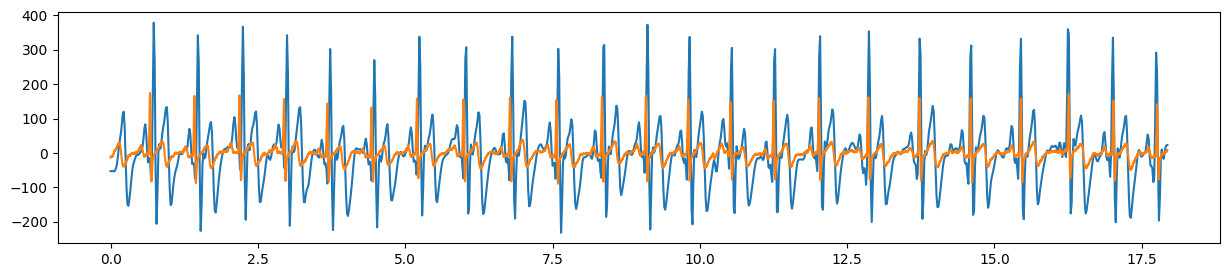

In [19]:
plt.figure(figsize=(15, 3))
plt.plot(downsampled_time_for_approx, approx_coeffs, time_full, ecg_full)

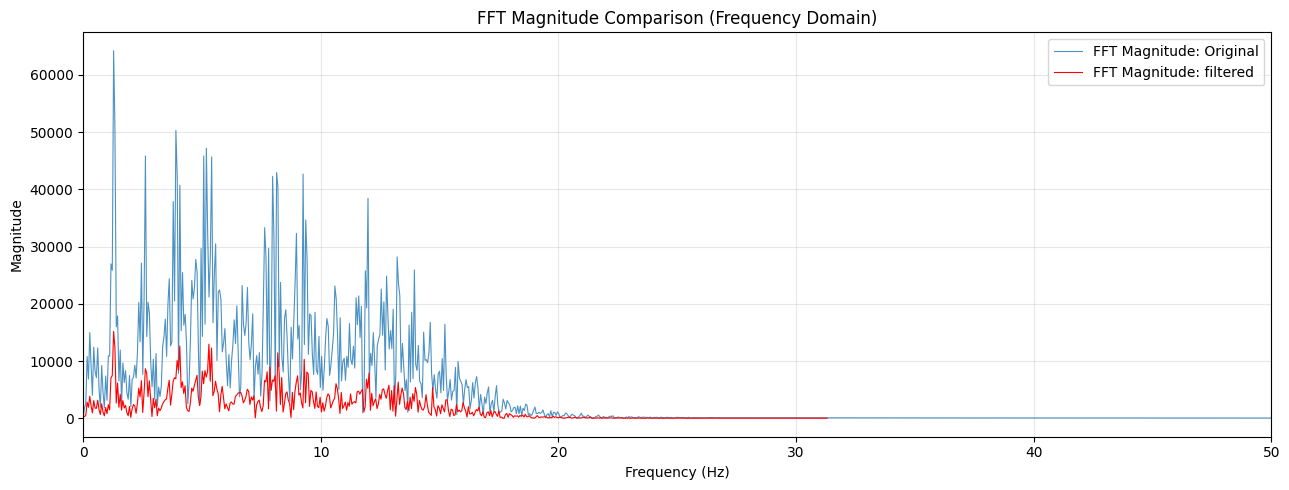

In [20]:
plot_fft_spectrum_compare(ecg_filtered_data, time_full, approx_coeffs, downsampled_time_for_approx )

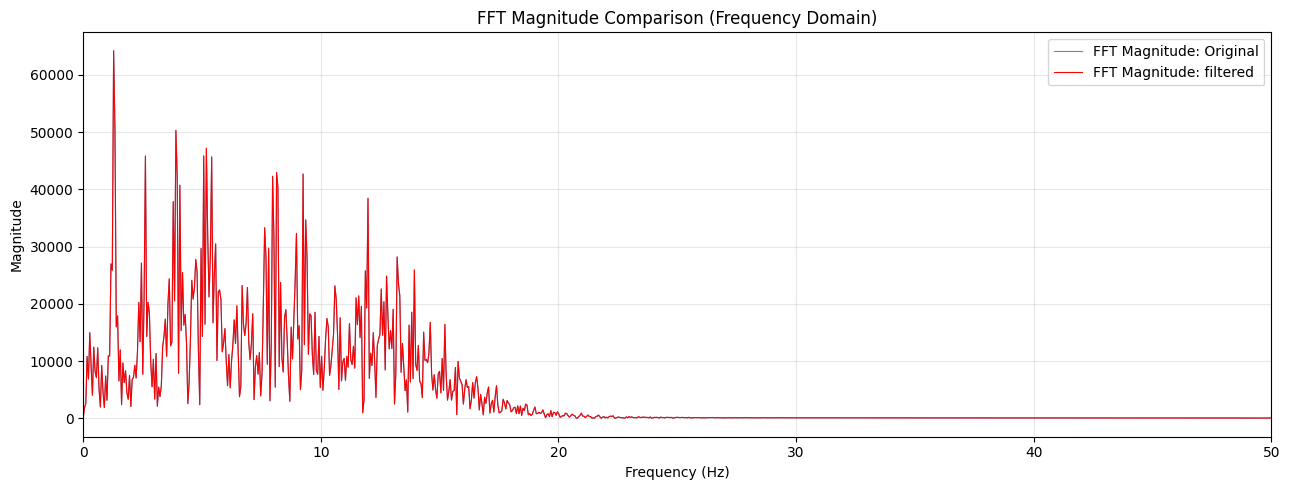

In [21]:
plot_fft_spectrum_compare(ecg_filtered_data, time_full, reconstructed_smooth_with_details_2, time_full)
#plot_fft_spectrum_compare(ecg_filtered_data, time_full, reconstructed_smooth_only, time_full)


--- Error Metrics for DWT Reconstruction (Approx + cD4 + cD3) ---
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0036
Mean Absolute Error (MAE): 0.0016
Maximum Absolute Error: 0.1363


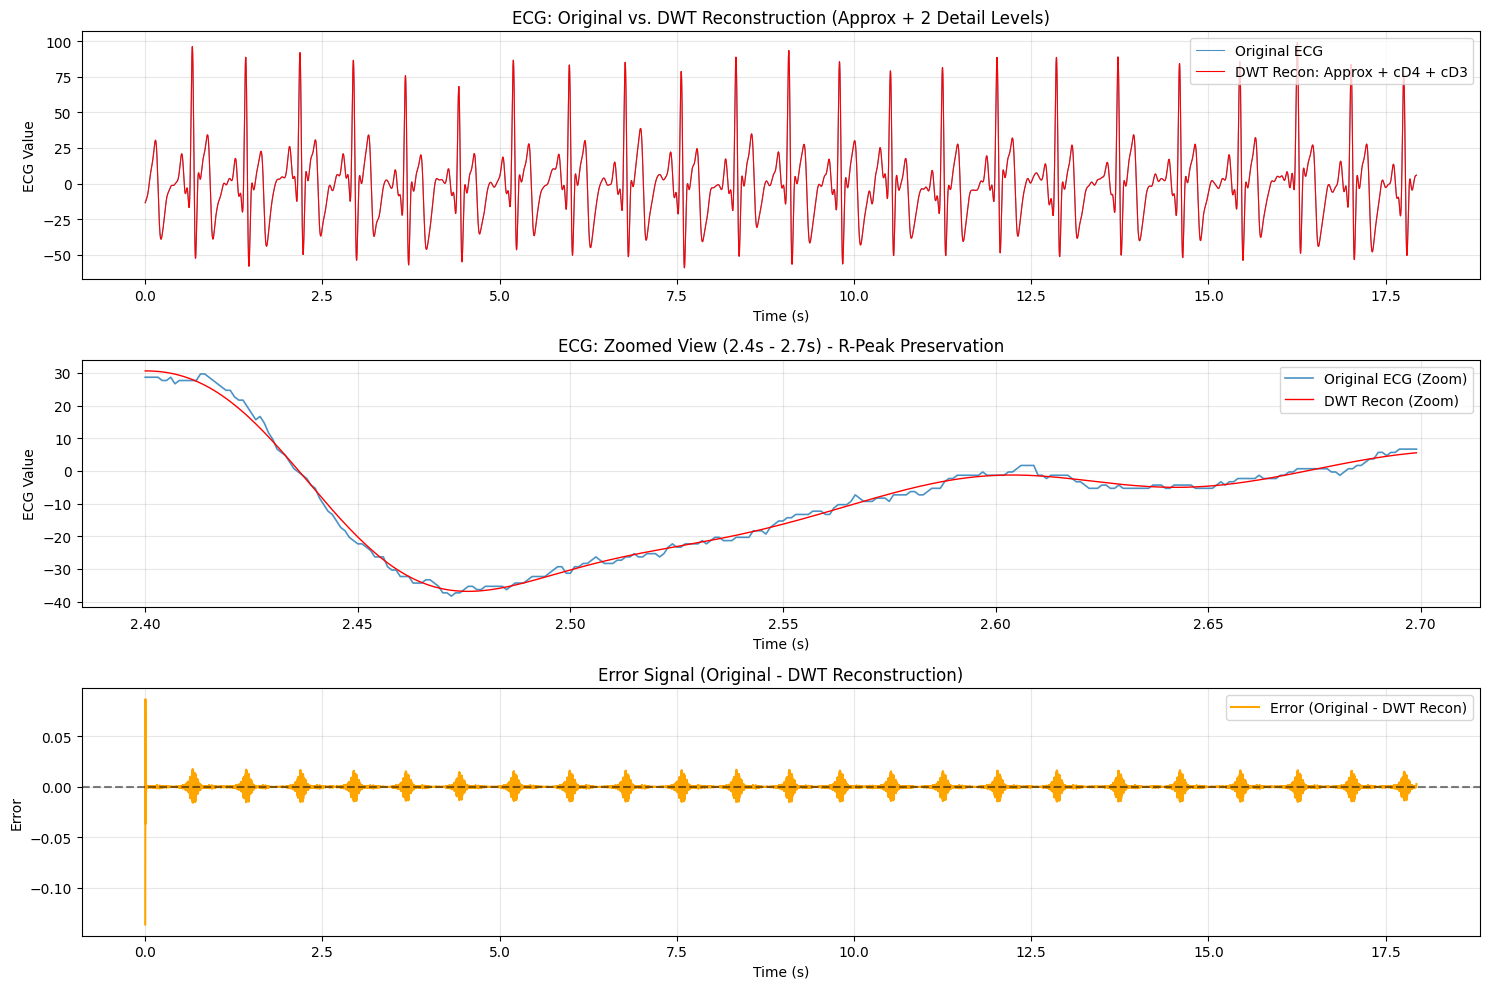

In [22]:
#print(f"DWT Approximation (Level {decomposition_level}) length: {len(approx_coeffs)}")

# --- Calculate Error ---
error_signal_chosen = ecg_filtered_data - reconstructed_smooth_with_details_2
mse_chosen = np.mean(error_signal_chosen**2)
rmse_chosen = np.sqrt(mse_chosen)
mae_chosen = np.mean(np.abs(error_signal_chosen))
max_error_chosen = np.max(np.abs(error_signal_chosen))

print("\n--- Error Metrics for DWT Reconstruction (Approx + cD4 + cD3) ---")
print(f"Mean Squared Error (MSE): {mse_chosen:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_chosen:.4f}")
print(f"Mean Absolute Error (MAE): {mae_chosen:.4f}")
print(f"Maximum Absolute Error: {max_error_chosen:.4f}")

# --- Visual Comparison ---
plt.figure(figsize=(15, 10))

# Plot 1: Full comparison
plt.subplot(3, 1, 1)
plt.plot(time_full, ecg_filtered_data, label='Original ECG', alpha=0.8, linewidth=0.8)
plt.plot(time_full, reconstructed_smooth_with_details_2, label=f'DWT Recon: Approx + cD{decomposition_level} + cD{decomposition_level-1}', color='red', linewidth=0.8)
plt.title('ECG: Original vs. DWT Reconstruction (Approx + 2 Detail Levels)')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed comparison on a section with R-peaks (example: 2.4s to 2.7s)
start_idx = int(2.4 / 0.001)  # Start around 2.4 seconds (assuming dt ~ 0.001)
end_idx = int(2.7 / 0.001)    # End around 2.7 seconds
time_zoom = time_full[start_idx:end_idx]
ecg_orig_zoom = ecg_full[start_idx:end_idx]
recon_smooth_d2_zoom = reconstructed_smooth_with_details_2[start_idx:end_idx]

plt.subplot(3, 1, 2)
plt.plot(time_zoom, ecg_orig_zoom, label='Original ECG (Zoom)', alpha=0.8, linewidth=1.2)
plt.plot(time_zoom, recon_smooth_d2_zoom, label='DWT Recon (Zoom)', color='red', linewidth=1)
plt.title('ECG: Zoomed View (2.4s - 2.7s) - R-Peak Preservation')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error signal
plt.subplot(3, 1, 3)
plt.plot(time_full, error_signal_chosen, label='Error (Original - DWT Recon)', color='orange')
plt.title('Error Signal (Original - DWT Reconstruction)')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) # Add zero line for reference

plt.tight_layout()
plt.show()

Reconstructed Smoothed ECG length: 17935
DWT Approximation (Level 2) length: 4489
Downsampled time length: 4489

--- Error Metrics between Original (Downsampled) and DWT Approximation ---
Mean Squared Error (MSE): 856.9926
Root Mean Squared Error (RMSE): 29.2744
Mean Absolute Error (MAE): 18.4154
Mean Absolute Percentage Error (MAPE): 296.63%
Maximum Absolute Error: 211.9778


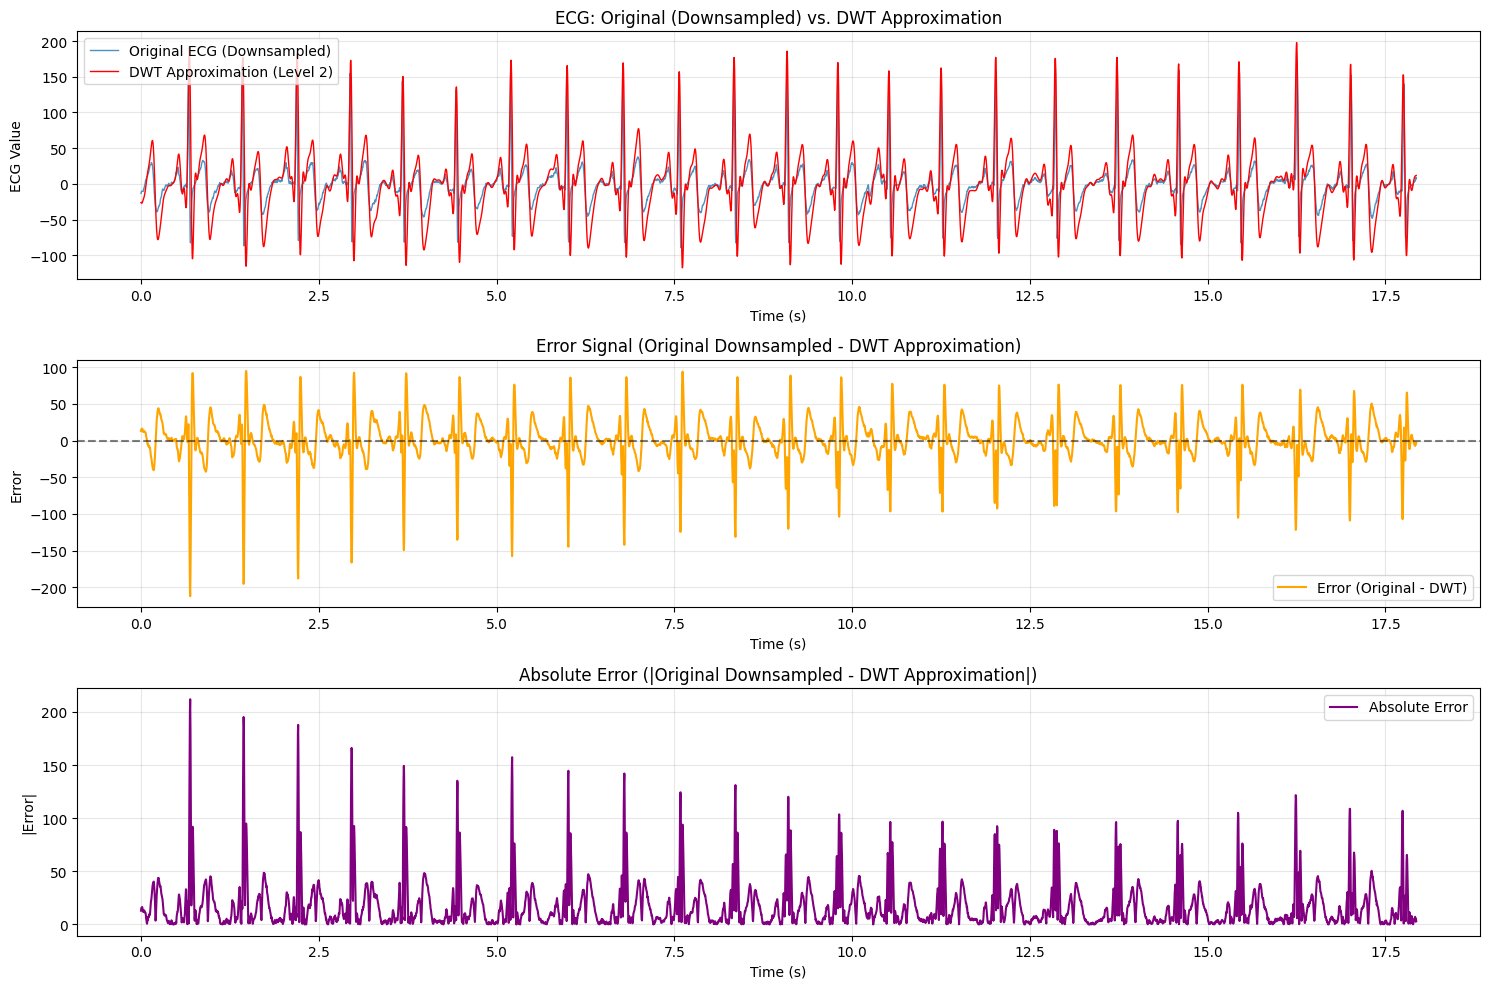

In [23]:
print(f"Reconstructed Smoothed ECG length: {len(reconstructed_smooth_with_details_2)}")

# --- Resample using DWT --- # coif5, db4, sym7
wavelet_name = 'db4'
level = 2

coeffs = pywt.wavedec(reconstructed_smooth_with_details_2, wavelet_name, level=level)
approx_coeffs = coeffs[0] # This is the downsampled version

# Calculate the corresponding downsampled time vector
downsampled_time = time_full[::2**level]
# Ensure the time vector matches the length of the approximation coefficients
if len(downsampled_time) > len(approx_coeffs):
    downsampled_time = downsampled_time[:len(approx_coeffs)]
elif len(downsampled_time) < len(approx_coeffs):
    downsampled_time = np.linspace(time_full[0], time_full[-1], len(approx_coeffs))

print(f"DWT Approximation (Level {level}) length: {len(approx_coeffs)}")
print(f"Downsampled time length: {len(downsampled_time)}")

# --- Calculate Error ---
# Downsample the original ECG signal to match the length of the approximation coefficients
ecg_full_downsampled = ecg_filtered_data[::2**level]
if len(ecg_full_downsampled) > len(approx_coeffs):
    ecg_full_downsampled = ecg_full_downsampled[:len(approx_coeffs)]
elif len(ecg_full_downsampled) < len(approx_coeffs):
    # This is unlikely if we calculated approx_coeffs correctly, but just in case
    ecg_full_downsampled = np.interp(downsampled_time, time_full, ecg_full)

# Calculate the difference (error) signal
error_signal = ecg_full_downsampled - approx_coeffs

# Calculate error metrics
mse = np.mean(error_signal**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(error_signal))
mape = np.mean(np.abs(error_signal / (ecg_full_downsampled + 1e-8))) * 100 # Add small value to avoid division by zero
max_error = np.max(np.abs(error_signal))

print("\n--- Error Metrics between Original (Downsampled) and DWT Approximation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Maximum Absolute Error: {max_error:.4f}")

# --- Plot Original (Downsampled), DWT Approximation, and Error ---
plt.figure(figsize=(15, 10))

# Plot 1: Original Downsampled vs DWT Approximation
plt.subplot(3, 1, 1)
plt.plot(downsampled_time, ecg_full_downsampled, label='Original ECG (Downsampled)', alpha=0.8, linewidth=1)
plt.plot(downsampled_time, approx_coeffs, label=f'DWT Approximation (Level {level})', color='red', linewidth=1)
plt.title('ECG: Original (Downsampled) vs. DWT Approximation')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error Signal
plt.subplot(3, 1, 2)
plt.plot(downsampled_time, error_signal, label='Error (Original - DWT)', color='orange')
plt.title('Error Signal (Original Downsampled - DWT Approximation)')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) # Add zero line for reference

# Plot 3: Absolute Error
plt.subplot(3, 1, 3)
plt.plot(downsampled_time, np.abs(error_signal), label='Absolute Error', color='purple')
plt.title('Absolute Error (|Original Downsampled - DWT Approximation|)')
plt.xlabel('Time (s)')
plt.ylabel('|Error|')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The error values are stored in 'error_signal', 'mse', 'rmse', 'mae', 'mape', 'max_error'

DWT Approximation used for smoothing (Level 4) length: 1127

--- Applying DWT for Downsampling to the Smoothed Signal ---
DWT Approximation (Level 2) length (Downsampled Signal): 4489
Downsampled time length: 4489

--- Error Metrics between Original (Downsampled) and DWT Downsampled Approximation ---
Mean Squared Error (MSE): 856.9926
Root Mean Squared Error (RMSE): 29.2744
Mean Absolute Error (MAE): 18.4154
Mean Absolute Percentage Error (MAPE): 296.63%
Maximum Absolute Error: 211.9778


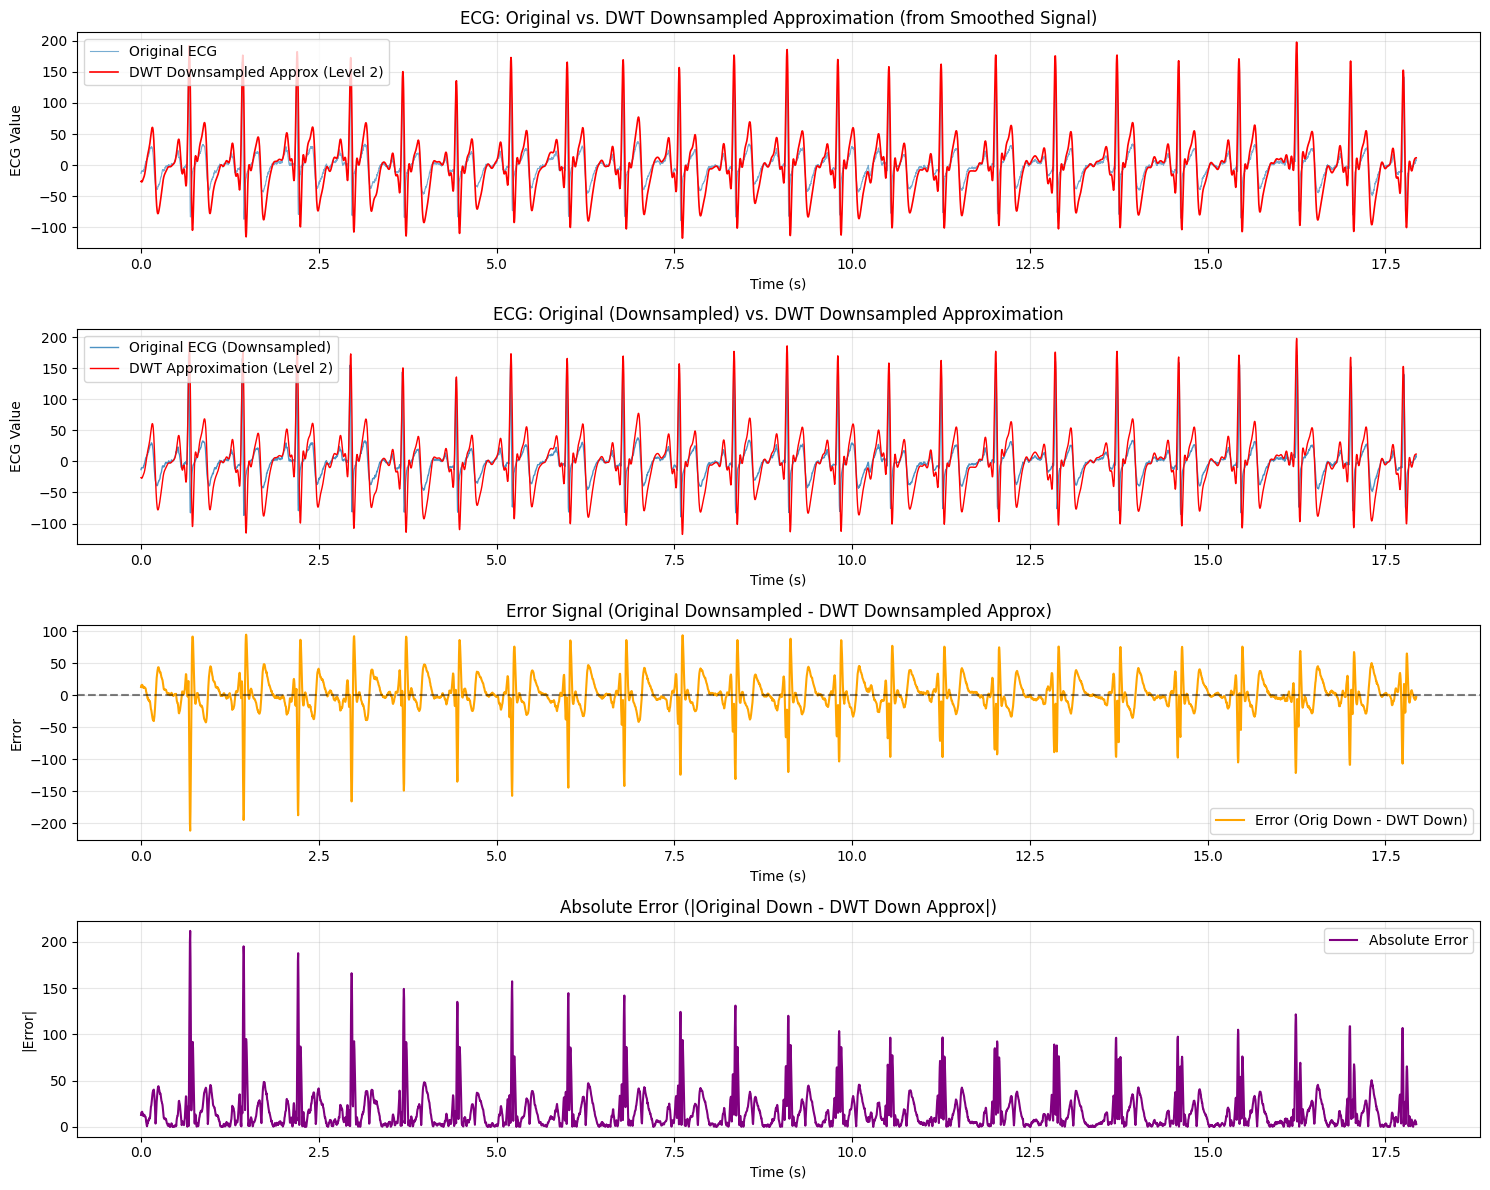

In [26]:
# Perform the full decomposition up to the specified level
coeffs_smooth = pywt.wavedec(reconstructed_smooth_with_details_2, wavelet_name, level=decomposition_level)
approx_coeffs_smooth = coeffs_smooth[0] # The smooth, low-frequency part

## Reconstruct using the approximation (cA) AND the first TWO levels of detail (cD4, cD3)
#detail_levels_to_keep_smooth = 2 # Keep cD4 and cD3
#reconstruction_coeffs_smooth = [approx_coeffs_smooth] + coeffs_smooth[1:1+detail_levels_to_keep_smooth] + [np.zeros_like(c) for c in coeffs_smooth[1+detail_levels_to_keep_smooth:]]
#reconstructed_smooth_with_details_2 = pywt.waverec(reconstruction_coeffs_smooth, wavelet_name)
## Ensure the reconstructed length matches the original (DWT might add padding)
#reconstructed_smooth_with_details_2 = reconstructed_smooth_with_details_2[:len(ecg_full)]

print(f"DWT Approximation used for smoothing (Level {decomposition_level}) length: {len(approx_coeffs_smooth)}")

# --- Now, Apply DWT again to the RECONSTRUCTED smoothed signal for downsampling ---
print(f"\n--- Applying DWT for Downsampling to the Smoothed Signal ---")
# Use the reconstructed smoothed signal as input for the next DWT
reconstruction_signal_to_downsample = reconstructed_smooth_with_details_2 # Use this as the signal to downsample

wavelet_name_downsample = 'db4' # Choose wavelet for downsampling
level_downsample = 2 # Choose downsampling level (2^2 = 4x downsampling)

coeffs_downsample = pywt.wavedec(reconstruction_signal_to_downsample, wavelet_name_downsample, level=level_downsample)
approx_coeffs_downsample = coeffs_downsample[0] # This is the downsampled version of the *reconstructed* signal

# Calculate the corresponding downsampled time vector based on the original time vector
downsampled_time = time_full[::2**level_downsample]
# Ensure the time vector matches the length of the approximation coefficients
if len(downsampled_time) > len(approx_coeffs_downsample):
    downsampled_time = downsampled_time[:len(approx_coeffs_downsample)]
elif len(downsampled_time) < len(approx_coeffs_downsample):
    downsampled_time = np.linspace(time_full[0], time_full[-1], len(approx_coeffs_downsample))

print(f"DWT Approximation (Level {level_downsample}) length (Downsampled Signal): {len(approx_coeffs_downsample)}")
print(f"Downsampled time length: {len(downsampled_time)}")

# --- Calculate Error ---
# Downsample the *original* ECG signal to match the length of the downsampled approximation coefficients
ecg_full_downsampled_for_comparison = ecg_full[::2**level_downsample]
if len(ecg_full_downsampled_for_comparison) > len(approx_coeffs_downsample):
    ecg_full_downsampled_for_comparison = ecg_full_downsampled_for_comparison[:len(approx_coeffs_downsample)]
elif len(ecg_full_downsampled_for_comparison) < len(approx_coeffs_downsample):
    # This is unlikely if we calculated approx_coeffs_downsample correctly, but just in case
    ecg_full_downsampled_for_comparison = np.interp(downsampled_time, time_full, ecg_full)

# Calculate the difference (error) signal between the *original* downsampled and the *downsampled reconstruction*
error_signal = ecg_full_downsampled_for_comparison - approx_coeffs_downsample

# Calculate error metrics
mse = np.mean(error_signal**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(error_signal))
mape = np.mean(np.abs(error_signal / (ecg_full_downsampled_for_comparison + 1e-8))) * 100 # Add small value to avoid division by zero
max_error = np.max(np.abs(error_signal))

print("\n--- Error Metrics between Original (Downsampled) and DWT Downsampled Approximation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Maximum Absolute Error: {max_error:.4f}")

# --- Plotting ---
plt.figure(figsize=(15, 12))

# Plot 1: Original Signal vs Downsampled DWT Approximation
plt.subplot(4, 1, 1)
plt.plot(time_full, ecg_full, label='Original ECG', alpha=0.6, linewidth=0.8)
plt.plot(downsampled_time, approx_coeffs_downsample, label=f'DWT Downsampled Approx (Level {level_downsample})', color='red', linewidth=1.2)
plt.title('ECG: Original vs. DWT Downsampled Approximation (from Smoothed Signal)')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Downsampled Original vs Downsampled DWT Approximation (Both on downsampled time axis)
plt.subplot(4, 1, 2)
plt.plot(downsampled_time, ecg_full_downsampled_for_comparison, label='Original ECG (Downsampled)', alpha=0.8, linewidth=1)
plt.plot(downsampled_time, approx_coeffs_downsample, label=f'DWT Approximation (Level {level_downsample})', color='red', linewidth=1)
plt.title('ECG: Original (Downsampled) vs. DWT Downsampled Approximation')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error Signal
plt.subplot(4, 1, 3)
plt.plot(downsampled_time, error_signal, label='Error (Orig Down - DWT Down)', color='orange')
plt.title('Error Signal (Original Downsampled - DWT Downsampled Approx)')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) # Add zero line for reference

# Plot 4: Absolute Error
plt.subplot(4, 1, 4)
plt.plot(downsampled_time, np.abs(error_signal), label='Absolute Error', color='purple')
plt.title('Absolute Error (|Original Down - DWT Down Approx|)')
plt.xlabel('Time (s)')
plt.ylabel('|Error|')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# The downsampled approximation coefficients are stored in 'approx_coeffs_downsample'
# The corresponding downsampled time vector is in 'downsampled_time'
# The error values are stored in 'error_signal', 'mse', 'rmse', 'mae', 'mape', 'max_error'

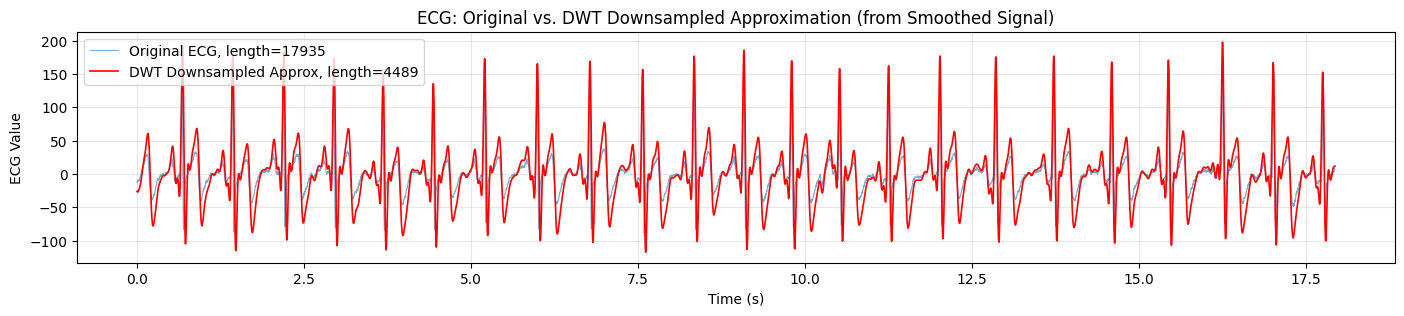

In [27]:
plt.figure(figsize=(17,3))
# Plot 1: Original Signal vs Downsampled DWT Approximation
plt.plot(time_full, ecg_full, label=f'Original ECG, length={len(ecg_full)}', alpha=0.6, linewidth=0.8)
plt.plot(downsampled_time, approx_coeffs_downsample, label=f'DWT Downsampled Approx, length={len(approx_coeffs_downsample)}', color='red', linewidth=1.2)
plt.title('ECG: Original vs. DWT Downsampled Approximation (from Smoothed Signal)')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True, alpha=0.3)

In [28]:
time_full = downsampled_time
ecg_full = approx_coeffs_downsample

dt_calculated = np.diff(time_full).mean()

# Define split: last 1 seconds for testing
test_duration_sec = 0.5
sampling_rate = int(np.round(1.0 / dt_calculated))
test_points = int(test_duration_sec * sampling_rate)

print(f"Assumed Sampling Rate: {sampling_rate} Hz")
print(f"Test Points (last {test_duration_sec}s): {test_points}")

time_train = time_full[:-test_points]
ecg_train = ecg_full[:-test_points]
time_test = time_full[-test_points:]
ecg_test_true = ecg_full[-test_points:]

print(f"Training points: {len(ecg_train)} ({time_train[-1] - time_train[0]:.2f}s)")
print(f"Testing points: {len(ecg_test_true)} ({time_test[-1] - time_test[0]:.2f}s)")

Assumed Sampling Rate: 250 Hz
Test Points (last 0.5s): 125
Training points: 4364 (17.43s)
Testing points: 125 (0.50s)


# Forecast model

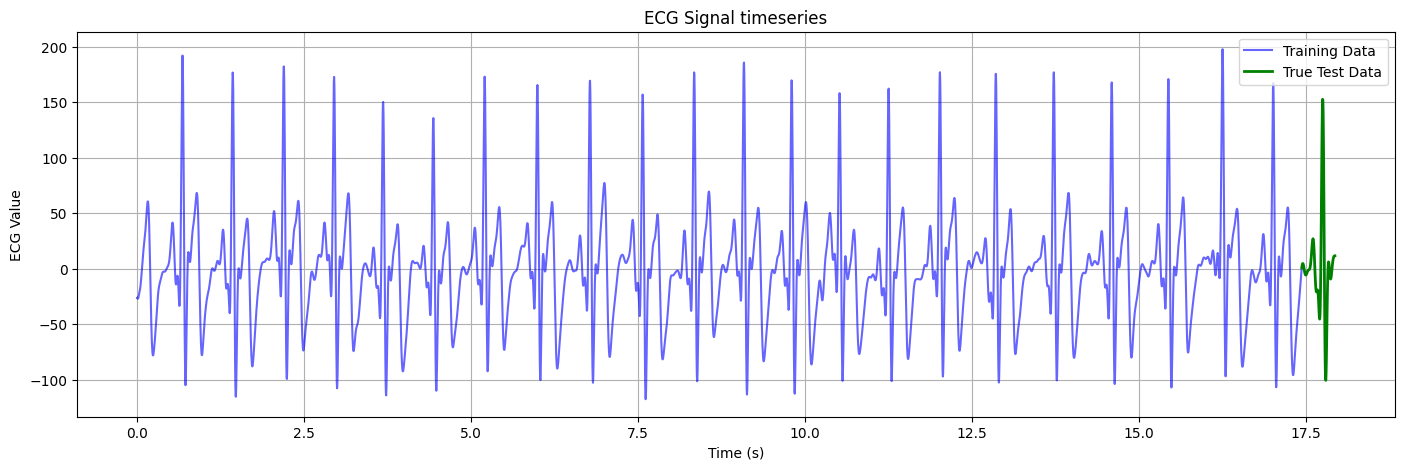

In [29]:
# Plot 1: Full time series with predictions highlighted
fig, axes = plt.subplots(1, 1, figsize=(17, 5))

axes.plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
axes.plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
axes.set_title('ECG Signal timeseries')
axes.set_xlabel('Time (s)')
axes.set_ylabel('ECG Value')
axes.legend()
axes.grid(True)

## ARIMA

In [30]:
# --- Method 1: ARIMA Model ---
print("\n--- Running ARIMA Model ---")
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
arima_model = ARIMA(ecg_train, order=(5, 1, 0))  # Example order (p, d, q)
arima_fitted_model = arima_model.fit()
print(arima_fitted_model.summary())

# Predict the test period (which is the rest of the signal based on the prompt)
arima_forecast = arima_fitted_model.forecast(steps=test_points)
print(f"ARIMA forecast shape: {arima_forecast.shape}")



--- Running ARIMA Model ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4364
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3952.401
Date:                Fri, 24 Oct 2025   AIC                          -7892.803
Time:                        04:44:38   BIC                          -7854.517
Sample:                             0   HQIC                         -7879.291
                               - 4364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.7056      0.006    648.154      0.000       3.694       3.717
ar.L2         -5.4480      0.012   -446.101      0.000      -5.472      -5.424
ar.L3          3.8828  

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average.
**bold text**

>P (Seasonal AR order): The number of lagged seasonal forecast errors (autoregressive terms) to include in the seasonal part of the model. It models how the current value is related to past values at multiples of the seasonal period.

>D (Seasonal Difference order): The number of times the data needs to be differenced with respect to the seasonal period to achieve seasonal stationarity. For example, if S=12 (monthly seasonality), D=1 means subtracting the value from 12 periods ago (y[t] - y[t-12]). If D=2, it means doing this seasonal differencing twice. This helps remove trends that repeat seasonally.

>Q (Seasonal MA order): The number of lagged seasonal forecast errors (moving average terms) to include in the seasonal part of the model. It models how the current value is related to the errors made in previous seasonal forecasts.

>S (Seasonal Period): The number of time steps (or observations) it takes for a single seasonal pattern to repeat itself. This is crucial and must be determined from the data or domain knowledge (e.g., 12 for monthly data with yearly seasonality, 4 for quarterly data with yearly seasonality, 24 for hourly data with daily seasonality, 50 or 100 for ECG data if there's a heartbeat-like cycle depending on sampling rate).

## SARIMA

In [31]:
# --- Method 2: SARIMA Model ---
print("\n--- Running SARIMA Model ---")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model on training data
# Using seasonal order (P, D, Q, S) where S is the seasonal period (e.g., 50 for ~50Hz sampling)
seasonal_order = (1, 1, 1, int(sampling_rate/10)) # Example seasonal order
sarima_model = SARIMAX(ecg_train, order=(2, 1, 0), seasonal_order=seasonal_order)
sarima_fitted_model = sarima_model.fit(disp=False)
print(sarima_fitted_model.summary())

# Predict the test period
sarima_forecast = sarima_fitted_model.forecast(steps=test_points)
print(f"SARIMA forecast shape: {sarima_forecast.shape}")


--- Running SARIMA Model ---
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 4364
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 25)   Log Likelihood               -1747.870
Date:                              Fri, 24 Oct 2025   AIC                           3505.740
Time:                                      04:46:13   BIC                           3537.616
Sample:                                           0   HQIC                          3516.993
                                             - 4364                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9197      0.001   1319.870      0.000       1.917  

## RNN

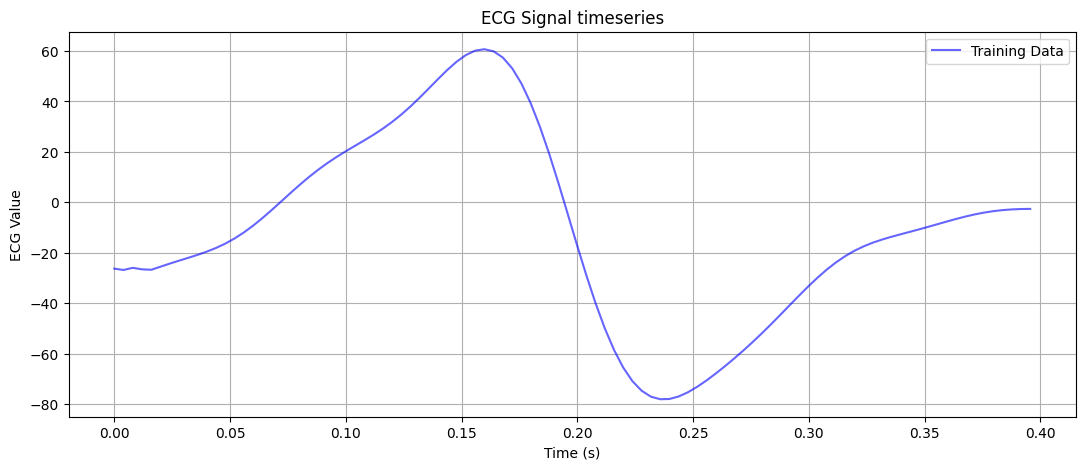

In [32]:
# Plot 1: RNN time series
fig, axes = plt.subplots(1, 1, figsize=(13, 5))
rnn_seq_length = 100
axes.plot(time_train[:rnn_seq_length], ecg_train[:rnn_seq_length], label='Training Data', color='blue', alpha=0.6)
axes.set_title('ECG Signal timeseries')
axes.set_xlabel('Time (s)')
axes.set_ylabel('ECG Value')
axes.legend()
axes.grid(True)

In [33]:
# --- Method 3: Simple RNN with PyTorch (Using StandardScaler) ---
print("\n--- Running Simple RNN Model (Using StandardScaler) ---")
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


--- Running Simple RNN Model (Using StandardScaler) ---
Using device: cpu


In [ ]:
# Prepare data for RNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --- Use StandardScaler for normalization ---
scaler = StandardScaler()
# Fit the scaler on the training data only
ecg_train_reshaped = ecg_train.reshape(-1, 1) # StandardScaler expects 2D array
scaler.fit(ecg_train_reshaped)

# Transform training and test data using the fitted scaler
ecg_train_norm_2d = scaler.transform(ecg_train_reshaped)
ecg_test_norm_2d = scaler.transform(ecg_test_true.reshape(-1, 1))

# Flatten back to 1D for sequence creation and prediction use
ecg_train_norm = ecg_train_norm_2d.flatten()
ecg_test_norm = ecg_test_norm_2d.flatten()

#rnn_seq_length = 1000  # Use 50 previous points to predict the next one

train_x, train_y = create_sequences(ecg_train_norm, rnn_seq_length)

# Convert to PyTorch tensors
train_x_tensor = torch.Tensor(train_x).to(device).unsqueeze(-1)  # Add feature dimension
train_y_tensor = torch.Tensor(train_y).to(device)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=150, num_layers=3, output_size=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)  # out shape: (batch, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

model = SimpleRNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_x_tensor)
    loss = criterion(output.squeeze(), train_y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# --- Corrected Prediction using StandardScaler ---
# To predict the test period, we need to start from the end of the training sequence.
# The initial sequence for the first prediction should be the last `seq_length` points of the *training* data (normalized).
model.eval()

# The sequence to start prediction should be the last `seq_length` points from the *normalized training* data
# This sequence ends with ecg_train_norm[-1], which corresponds to ecg_train[-1]
initial_seq_norm = ecg_train_norm[-rnn_seq_length:].copy()
print(f"Initial sequence shape: {initial_seq_norm.shape}")
print(f"Initial sequence starts with normalized value: {initial_seq_norm[0]:.4f} (original ~ {ecg_train[-rnn_seq_length]:.2f})")
print(f"Initial sequence ends with normalized value: {initial_seq_norm[-1]:.4f} (original ~ {ecg_train[-1]:.2f})")
print(f"This end value should match the last training value: {ecg_train[-1]:.2f}")

rnn_predictions_norm = [] # Store normalized predictions first
current_seq_norm = initial_seq_norm # Start with the sequence from the end of training

for i in range(test_points):
    # Prepare the current sequence as a tensor for the model
    seq_tensor = torch.Tensor(current_seq_norm).to(device).unsqueeze(0).unsqueeze(-1) # Shape: (1, seq_len, 1)

    with torch.no_grad():
        # Get the normalized prediction
        pred_norm_single = model(seq_tensor).item()

    # Append the normalized prediction
    rnn_predictions_norm.append(pred_norm_single)

    # Update the sequence for the next prediction:
    # Remove the first element, append the new prediction
    current_seq_norm = np.append(current_seq_norm[1:], pred_norm_single)

# Convert list of normalized predictions to numpy array
rnn_predictions_norm_array = np.array(rnn_predictions_norm)

# --- Denormalize the predictions using the inverse transform ---
# The scaler expects a 2D array, so reshape, transform, then flatten
rnn_predictions_norm_2d = rnn_predictions_norm_array.reshape(-1, 1)
rnn_predictions = scaler.inverse_transform(rnn_predictions_norm_2d).flatten()

print(f"RNN predictions shape: {rnn_predictions.shape}")
print(f"First RNN prediction (denormalized): {rnn_predictions[0]:.2f}")
print(f"This should be the prediction for the point immediately after ecg_train[-1] (time: {time_train[-1] + dt_calculated:.3f})")
print(f"The value ecg_train[-1] was: {ecg_train[-1]:.2f}")

In [ ]:
# --- Plotting the Results ---
print("\n--- Plotting Results ---")
plt.figure(figsize=(15, 3))
plt.plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
plt.plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
plt.plot(time_test, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(time_test, sarima_forecast, label='SARIMA Forecast', color='orange', linestyle='--')
plt.plot(time_test, rnn_predictions, label='RNN Prediction', color='purple', linestyle='-.')
plt.title('ECG Signal Prediction Comparison')
plt.xlabel('Time (s)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Calculate and Print Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(true, pred, model_name):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print("\n--- Model Performance Metrics (on Test Set) ---")
calculate_metrics(ecg_test_true, arima_forecast, "ARIMA")
calculate_metrics(ecg_test_true, sarima_forecast, "SARIMA")
calculate_metrics(ecg_test_true, rnn_predictions, "RNN")

In [ ]:
# Additional code to add confusion matrix and enhanced visualization

# --- 1. Confusion Matrix for Time Series Classification ---
# For time series forecasting, we'll convert the continuous values to classes for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_class_labels(values, n_classes=5):
    """Convert continuous values to class labels based on quantiles"""
    quantiles = np.quantile(values, np.linspace(0, 1, n_classes + 1))
    # Handle potential duplicate quantile values
    quantiles = np.unique(quantiles)
    if len(quantiles) < n_classes + 1:
        # If not enough unique quantiles, use linspace
        quantiles = np.linspace(np.min(values), np.max(values), n_classes + 1)
    labels = np.digitize(values, quantiles) - 1
    # Ensure labels are within [0, n_classes-1]
    labels = np.clip(labels, 0, n_classes - 1)
    return labels, quantiles

# Create class labels for true test values
n_classes = 5
true_labels, _ = create_class_labels(ecg_test_true, n_classes)

# Create class labels for predictions
arima_labels, _ = create_class_labels(arima_forecast, n_classes)
sarima_labels, _ = create_class_labels(sarima_forecast, n_classes)
rnn_labels, _ = create_class_labels(rnn_predictions, n_classes)

# Calculate confusion matrices
cm_arima = confusion_matrix(true_labels, arima_labels, labels=range(n_classes))
cm_sarima = confusion_matrix(true_labels, sarima_labels, labels=range(n_classes))
cm_rnn = confusion_matrix(true_labels, rnn_labels, labels=range(n_classes))

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
class_names = [f'Class {i}' for i in range(n_classes)]

sns.heatmap(cm_arima, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('ARIMA Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm_sarima, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('SARIMA Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_title('RNN Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# --- 2. Enhanced Visualization ---
# Following the style from the provided link
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Full time series with predictions highlighted
axes[0, 0].plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
axes[0, 0].plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
axes[0, 0].plot(time_test, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
axes[0, 0].plot(time_test, sarima_forecast, label='SARIMA Forecast', color='orange', linestyle='--')
axes[0, 0].plot(time_test, rnn_predictions, label='RNN Prediction', color='purple', linestyle='-.')
axes[0, 0].set_title('ECG Signal Prediction Comparison')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('ECG Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Zoomed-in view of test period
axes[0, 1].plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
axes[0, 1].plot(time_test, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
axes[0, 1].plot(time_test, sarima_forecast, label='SARIMA Forecast', color='orange', linestyle='--')
axes[0, 1].plot(time_test, rnn_predictions, label='RNN Prediction', color='purple', linestyle='-.')
axes[0, 1].set_title('Zoomed View: Test Period Predictions')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('ECG Value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Residuals for each model
residuals_arima = ecg_test_true - arima_forecast
residuals_sarima = ecg_test_true - sarima_forecast
residuals_rnn = ecg_test_true - rnn_predictions

axes[1, 0].plot(time_test, residuals_arima, label='ARIMA Residuals', color='red')
axes[1, 0].plot(time_test, residuals_sarima, label='SARIMA Residuals', color='orange')
axes[1, 0].plot(time_test, residuals_rnn, label='RNN Residuals', color='purple')
axes[1, 0].set_title('Residuals Comparison')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot 4: Scatter plot - True vs Predicted
axes[1, 1].scatter(ecg_test_true, arima_forecast, alpha=0.5, label='ARIMA', color='red')
axes[1, 1].scatter(ecg_test_true, sarima_forecast, alpha=0.5, label='SARIMA', color='orange')
axes[1, 1].scatter(ecg_test_true, rnn_predictions, alpha=0.5, label='RNN', color='purple')
# Add perfect prediction line
min_val = min(np.min(ecg_test_true), np.min([np.min(arima_forecast), np.min(sarima_forecast), np.min(rnn_predictions)]))
max_val = max(np.max(ecg_test_true), np.max([np.max(arima_forecast), np.max(sarima_forecast), np.max(rnn_predictions)]))
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axes[1, 1].set_title('True vs Predicted Values')
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Additional plot: Model performance metrics comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
models = ['ARIMA', 'SARIMA', 'RNN']
mse_values = [mean_squared_error(ecg_test_true, arima_forecast),
              mean_squared_error(ecg_test_true, sarima_forecast),
              mean_squared_error(ecg_test_true, rnn_predictions)]
mae_values = [mean_absolute_error(ecg_test_true, arima_forecast),
              mean_absolute_error(ecg_test_true, sarima_forecast),
              mean_absolute_error(ecg_test_true, rnn_predictions)]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, mse_values, width, label='MSE', alpha=0.8)
ax.bar(x + width/2, mae_values, width, label='MAE', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (mse, mae) in enumerate(zip(mse_values, mae_values)):
    ax.text(i - width/2, mse + max(mse_values) * 0.01, f'{mse:.2f}', ha='center', va='bottom')
    ax.text(i + width/2, mae + max(mae_values) * 0.01, f'{mae:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()